##STEP 1 : Generate directed and undirected graphs from train.csv

In [1]:
import networkx as nx
import requests
import csv
from io import StringIO

def get_directed_graph(file):
    G = nx.DiGraph()
    count = 1
    for row_data in file:
        if count % 1000 == 0:
            print(count)
        node = int(row_data[0])
        for neighbor in row_data[1:]:
            G.add_edge(node, int(neighbor))
        count +=1

    return G


def get_undirected_graph(file):
    G = nx.Graph()
    count = 1
    for row_data in file:
        if count % 1000 == 0:
            print(count)
        node = int(row_data[0])
        for neighbor in row_data[1:]:
            G.add_edge(node, int(neighbor))
        count +=1

    return G

#Read remote train.csv and parse it with csvreader:
url = 'https://media.githubusercontent.com/media/NeerajSura/PML/main/LinkPrediction/train.csv'
response = requests.get(url)
content = response.text
csv_reader = csv.reader(StringIO(content))


UG = get_undirected_graph(csv_reader)
#DG = get_directed_graph(csv_reader)
print("Number of nodes:", UG.number_of_nodes())
print("Number of edges:", UG.number_of_edges())



1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
Number of nodes: 4867136
Number of edges: 23415200


## Step 2 : Generate positive and negative samples from train.csv

In [ ]:
# create a train_dic dictionary which will be used for sampling
def make_train_data_dict(url):
  #Read remote train.csv and parse it with csvreader:
  response = requests.get(url)
  content = response.text
  csv_reader = csv.reader(StringIO(content))

  train_dict = {}
  for row in csv_reader:
    neighbor_list = [int(i) for i in row]
    train_dict[neighbor_list[0]] = set(neighbor_list[1:])
  return train_dict

# Get unique values of sources and sinks from train.csv
def get_train_sources_and_sinks_from_csv(url):
  #Read remote train.csv and parse it with csvreader:
  response = requests.get(url)
  content = response.text
  csv_reader = csv.reader(StringIO(content))

  sources = set()
  sinks = set()
  for row in csv_reader:
    sources.add(int(row[0]))
    for i in range(1, len(row)):
      sinks.add(int(row[i]))
  return sources, sinks


print("Making train dictionary from train.csv ...")
train_dict = make_train_data_dict(url)
print("Dictionary created successfully.")

train_sources, train_sinks = get_train_sources_and_sinks_from_csv(url)
print("Number of sources:", len(train_sources))
print("Number of sinks:", len(train_sinks))


Making train dictionary from train.csv ...
Dictionary created successfully.
Number of sources: 20000
Number of sinks: 4867136


In [ ]:
#Generate positive and negative pairs
import random
import numpy as np

def positive_sampling(n_samples):
    print(f"Sampling {n_samples} Positive pairs")
    positive_samples=[]
    count=0
    for i in range(n_samples):
        if (count % 1000 == 0):
            print(count)
        count+=1
        source_random_index=random.randint(0,19999)
        source=(list(train_sources))[source_random_index]
        chosen_source_sinks=train_dict[source] # fetch neighbors of selected source from train_dict
        try:
            sink=random.choice(list(chosen_source_sinks)) # chose any random neighbor
            positive_samples.append((source,sink)) # append to the list
        except:
            pass
    print('Length of positive samples list is :', len(positive_samples))
    return positive_samples


def negative_sampling(n_samples):
    print(f"Sampling {n_samples} Negative pairs")
    negative_samples=[]
    count = 0
    for i in range(n_samples):
        if (count % 1000 == 0):
            print(count)
        count+=1
        source_random_index=random.randint(0,19999)
        source=(list(train_sources))[source_random_index]
        chosen_source_sinks=train_dict[source] # fetch neighbors of selected source from train_dict
        sink=random.choice(list(train_sinks)) # Choose any random neighbor node from any source
        if sink not in chosen_source_sinks: # If chosen neighbor is not in the neighbors of chosen source then we have a negative pair
            negative_samples.append((source, sink))
    print('Length of negative samples list is :', len(negative_samples))
    return negative_samples

num_samples = 20000
positive_samples=positive_sampling(num_samples)
np.save('positive_samples.npy',np.array(positive_samples)) # Save as np array for future reference

negative_samples=negative_sampling(num_samples)
np.save('negative_samples.npy',np.array(negative_samples)) # Save as np array for future reference


Sampling 20000 Positive pairs
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
Length of positive samples list is : 19552
Sampling 20000 Negative pairs
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
Length of negative samples list is : 19994


In [ ]:
from google.colab import files
files.upload()

In [3]:
import pandas as pd
import numpy as np

positive_samples=np.load("20K_positive_samples.npy").tolist()
negative_samples=np.load("20K_negative_samples.npy").tolist()

def get_test_samples():
    test_data = pd.read_csv('test.csv')
    columns_to_convert = ['From', 'To']
    test_samples = test_data[columns_to_convert].values
    return test_samples.tolist()
test_samples = get_test_samples()

## STEP 3 : Feature Engineering

####1.Undirected Graph Features

In [11]:
import networkx as nx
import csv
import numpy as np

def extract_features_positive_samples():
    features = []
    count = 0
    print("Generating positive samples features......")
    for sample in positive_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            preds = nx.resource_allocation_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.jaccard_coefficient(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.adamic_adar_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.preferential_attachment(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            feature.append(1)  # label=1

        except Exception as e:
            print("one error at: "+str(count))
            print(e)
            pass
        features.append(feature)
    print("positive samples features: "+str(len(features)))
    return features


def extract_features_negative_samples():
    features = []
    count = 0
    print("Generating negative samples features......")
    for sample in negative_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            preds = nx.resource_allocation_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.jaccard_coefficient(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.adamic_adar_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.preferential_attachment(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            feature.append(0)  # label=0
        except Exception as e:
            print("one error at: "+str(count))
            print(e)
            pass
        features.append(feature)

    print("negative samples features: "+str(len(features)))
    return features

def extract_features_test_samples():
    features = []
    count = 0
    print("Generating test samples features......")
    for sample in test_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            preds = nx.resource_allocation_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.jaccard_coefficient(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.adamic_adar_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.preferential_attachment(UG, [sample])
            for u, v, p in preds:
                feature.append(p)
        except Exception as e:
            print("one error at: "+str(len(count)))
            print(e)
            pass
        features.append(feature)

    return features

# add features and label, combine
def generate_traning_data_from_UG():
    positive_features_ug = extract_features_positive_samples()
    negative_features_ug = extract_features_negative_samples()
    features_ug = positive_features_ug + negative_features_ug
    # random.shuffle(features)
    return features_ug


traning_data_ug = generate_traning_data_from_UG()

def write_train_to_csv(traning_data):
    with open("train_ug_20k_samples.csv","w",newline="") as csvfile:
        writer=csv.writer(csvfile)
        writer.writerow(["RA","JC","AA","PA","Label"])
        writer.writerows(traning_data)

write_train_to_csv(traning_data_ug)

def write_test_to_csv(test_data):
    with open("test_ug_20k_samples.csv","w",newline="") as csvfile:
        writer=csv.writer(csvfile)
        writer.writerow(["RA","JC","AA","PA"])
        writer.writerows(test_data)

test_data=extract_features_test_samples()
write_test_to_csv(test_data)



Generating positive samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
positive samples features: 19588
Generating negative samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
negative samples features: 19995
Generating test samples features......
0
1000


####2.Sparse Adjacency Matrix Features

In [5]:
# Construct Adjacency Matrix
import requests
from scipy.sparse import csr_matrix

print("Generating matrix......")

# Fetching CSV data from GitHub
url = 'https://github.com/NeerajSura/PML/raw/main/LinkPrediction/train.csv'
response = requests.get(url)

row = []
col = []
data = []

# Parsing CSV data
for line in response.text.split('\n'):
    if line.strip():  # Check if the line is not empty
        neighbour_list = [int(i) for i in line.split(',') if i.strip()]  # Remove empty values
        for i in range(1, len(neighbour_list)):
            row.append(neighbour_list[0])
            col.append(neighbour_list[i])
            data.append(1)

# Constructing CSR matrices
source_sink_matrix = csr_matrix((data, (row, col)), shape=(4867136, 4867136))
sink_source_matrix = csr_matrix((data, (col, row)), shape=(4867136, 4867136))

Generating matrix......


In [6]:
from math import sqrt

def cos_sim(X,Y):
    try:
        return (np.dot(X,Y.T)/(sqrt(X.nnz)*sqrt(Y.nnz))).toarray()[0][0]
    except:
        return 0

def pre_pre_cos(key1,key2):
    return cos_sim(sink_source_matrix[key1],sink_source_matrix[key2])
def suc_pre_cos(key1,key2):
    return cos_sim(source_sink_matrix[key1],sink_source_matrix[key2])


In [7]:
def extract_features_positive_samples():
    features = []
    count = 0
    print("Generating positive samples features......")
    for sample in positive_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            feature.append(pre_pre_cos(sample[0], sample[1]))
            feature.append(suc_pre_cos(sample[0], sample[1]))
            feature.append(1)  # label=1

        except Exception as e:
            print(e)
            pass
        features.append(feature)
    print("positive samples features: " + str(len(features)))
    return features

def extract_features_negative_samples():
    features = []
    count = 0
    print("Generating negative samples features......")
    for sample in negative_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            feature.append(pre_pre_cos(sample[0], sample[1]))
            feature.append(suc_pre_cos(sample[0], sample[1]))
            feature.append(0)  # label=0
        except:
            print("one error at: " + str(count))
            pass
        features.append(feature)
    print("negative samples features: " + str(len(features)))
    return features

def extract_features_test_samples():
    features = []
    count = 0
    print("Generating test samples features......")
    for sample in test_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            feature.append(pre_pre_cos(sample[0], sample[1]))
            feature.append(suc_pre_cos(sample[0], sample[1]))
        except:
            print("one error at: " + str(count))
            pass
        features.append(feature)
    print("test samples features: " + str(len(features)))
    return features


def generate_traning_data_from_CSR():
    positive_features_csr = extract_features_positive_samples()
    negative_features_csr = extract_features_negative_samples()
    features_csr = positive_features_csr + negative_features_csr
    # random.shuffle(features)
    return features_csr

traning_data = generate_traning_data_from_CSR()

def write_train_to_csv(traning_data):
    with open("train_csr_20k_samples.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["PPS", "SPS","Label"])
        writer.writerows(traning_data)
write_train_to_csv(traning_data)

def write_test_to_csv(test_data):
    with open("test_csr_20k_samples.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["PPS", "SPS"])
        writer.writerows(test_data)
test_data = extract_features_test_samples()
write_test_to_csv(test_data)


Generating positive samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
positive samples features: 19588
Generating negative samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
negative samples features: 19995
Generating test samples features......
0
1000
test samples features: 2000


## STEP 4 : Modelling


####1. Logistic Regression

In [ ]:
from google.colab import files
files.upload()

In [2]:
import pandas as pd
# Importing the dataset
dataset = pd.read_csv('train_merged_20k_samples.csv')
dataset

,RA,JC,AA,PA,PPS,SPS,Label
0,0.000000,0.000000,0.000000,665,0.000000,0.000000,1
1,0.000000,0.000000,0.000000,6,0.000000,0.000000,1
2,0.083930,0.110465,3.288578,7638,0.364405,0.242831,1
3,0.000000,0.000000,0.000000,66,0.000000,0.000000,1
4,0.022514,0.024390,0.866209,2000,0.271163,0.113813,1
...,...,...,...,...,...,...,...
39578,0.000000,0.000000,0.000000,330,0.000000,0.000000,0
39579,0.000000,0.000000,0.000000,126,0.000000,0.000000,0
39580,0.000000,0.000000,0.000000,368,0.000000,0.000000,0
39581,0.000000,0.000000,0.000000,23,0.000000,0.000000,0


In [3]:
FEATURE_SIZE=6
feature_names = dataset.columns[:FEATURE_SIZE]
print(feature_names)

X = dataset.iloc[:,0:FEATURE_SIZE].values
y = dataset.iloc[:, FEATURE_SIZE].values


Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')


In [4]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [5]:
x_train.shape

(31666, 6)

In [6]:
y_train

array([0, 0, 0, ..., 0, 1, 1])

C: 10 AUC Score: 0.8663161418027452 Selected Features: Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')
C: 100 AUC Score: 0.8685779092742456 Selected Features: Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')
C: 1000 AUC Score: 0.8716151517325526 Selected Features: Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')
C: 10000 AUC Score: 0.8725828120097233 Selected Features: Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')
C: 100000 AUC Score: 0.8728864724278256 Selected Features: Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')
C: 1000000 AUC Score: 0.8729560765657006 Selected Features: Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')


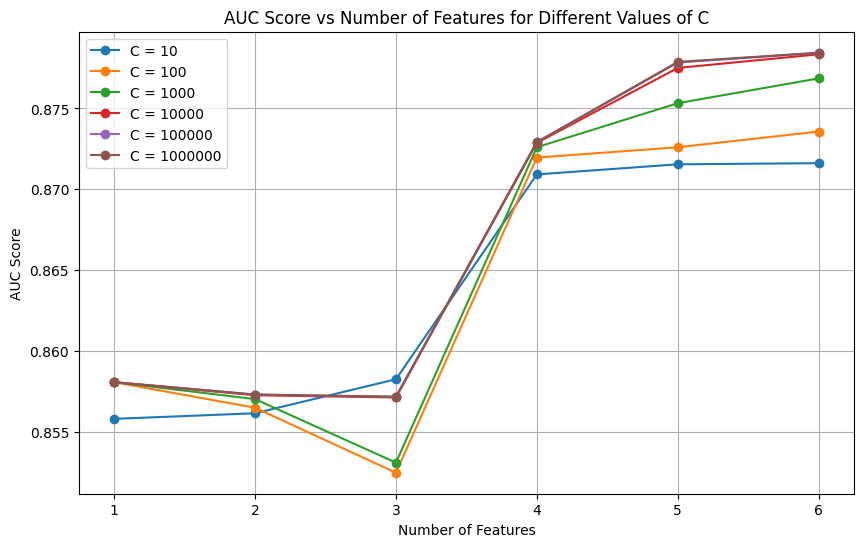

Best AUC Score: 0.8729560765657006
Best C: 1000000
Selected features: Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')
Best Classifier:
LogisticRegression(C=1000000, max_iter=1000)


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# List of values for C
param_C = [10, 100, 1000, 10000, 100000, 1000000]

best_auc_score = 0
best_selected_features = None
best_C = None
best_clf = None  # Initialize best classifier
auc_scores = []
num_features = []

for C in param_C:
    # Initialize Logistic Regression
    clf = LogisticRegression(max_iter=1000, C=C, penalty='l2')

    # Initialize RFECV for feature selection
    rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='roc_auc')

    # Fit RFECV
    rfecv.fit(x_train, y_train)

    # Transform datasets with selected features
    x_train_selected = rfecv.transform(x_train)
    x_test_selected = rfecv.transform(x_test)

    # Train classifier with selected features
    clf.fit(x_train_selected, y_train)

    # Predict probabilities
    y_pred_proba = clf.predict_proba(x_test_selected)[:, 1]

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Print AUC score for the current value of C
    print("C:", C, "AUC Score:", auc_score, "Selected Features:", feature_names[rfecv.support_])

    # Update best AUC score, selected features, and classifier if the current AUC score is better
    if auc_score > best_auc_score:
        best_auc_score = auc_score
        best_selected_features = feature_names[rfecv.support_]
        best_C = C
        best_clf = clf

    auc_scores.append(rfecv.cv_results_['mean_test_score'])
    num_features.append(range(1, len(rfecv.cv_results_['mean_test_score']) + 1))

# Plot the AUC scores against the number of features
plt.figure(figsize=(10, 6))
for auc, features in zip(auc_scores, num_features):
    plt.plot(features, auc, marker='o')

plt.xlabel('Number of Features')
plt.ylabel('AUC Score')
plt.title(f'AUC Score vs Number of Features for Different Values of C')
plt.grid(True)
plt.legend([f'C = {c}' for c in param_C])
plt.show()

# Print the best AUC score and selected features
print("Best AUC Score:", best_auc_score)
print("Best C:", best_C)
print("Selected features:", best_selected_features)

# Print the best classifier
print("Best Classifier:")
print(best_clf)

In [10]:
testdata = pd.read_csv('test_merged_20k_samples.csv')
x_testing = testdata.iloc[:,0:len(best_selected_features.tolist())].values
sc = StandardScaler()
x_testing = sc.fit_transform(x_testing)
x_testing = sc.transform(x_testing)
predictions=best_clf.predict_proba(x_testing)

In [11]:
import csv
with open("Predictions_Exp4.csv","w",newline="") as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(["Id","Predictions"])
    test_id=1
    for prediction in predictions:
        writer.writerow([test_id,prediction[1]])
        test_id+=1